In [1]:
import numpy as np
import matplotlib.pyplot as plt
import regex
from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree
import warnings

In [21]:
class Trajectory:
    '''
    Class to parse, manipulate and plot the lammps-trajectory objects.
    Takes one input argument 'file' which is the filepath of the .lammpstrj file to initialize
    - added functionality to also parse gromac trajectory .gro files.
    - TODO:: parse atom count from file instead of hardcode dummy -> only for gromac 
    '''

    def __init__(self, file, format='lammpstrj'):
        '''
        init of trajectory class
        :param file: file path to get the trajectory from
        :param format: default "lammpstrj", optional "gromac" or "XDATCAR"
                NOTE: if you want to add more formats make sure to include the apropriate format_to_np() parsers 
                with the same output format as the included ones.
        '''
        self.file = file
        if format == 'lammpstrj':
            self.trajectory, self.box_dim, self.n_atoms = self.lammpstrj_to_np()
        if format == 'gromac':
               self.trajectory, self.box_dim = self.gromac_to_np()
        if format == 'XDATCAR':
            self.trajectory, self.box_dim = self.xdatcar_to_np()
        self.n_snapshots = len(self.box_dim)
        self.s1 = 0
        self.s2 = 0
        self.box_size = 0
        self.indexlist = 0
        self.distance = 0
        self.ion_distance = 0
        
    def xdatcar_to_np(self):
        '''
        Method to parse vasp-xdatcar style formated trajectories
        :param file: string giving the XDATCAR file path
        :return: returns n_dim np array with the trajectory at each snapshot and a list of the current box dimensions
        ''' 

        snap_count = 0
        snap_lines = []
        n_atoms = 0

        with open(self.file) as f:
            for line_number, line in enumerate(f):

                if regex.match("Direct", line):
                    snap_count += 1
                    snap_lines.append(line_number + 1)
                    #print(snap_count)    
                if line_number == 6:
                    n_atoms = sum([int(i) for i in line.split()])
                    next

        atom_list = np.zeros((snap_count, n_atoms , 5))
        ind_list = [np.zeros(0) for _ in range(snap_count)]
        box_ind_list = [np.zeros(0) for _ in range(snap_count)]
        box_list = np.zeros((snap_count, 3, 3))
        box_lines = [i - 6 for i in snap_lines]
        for i in range(snap_count):
            ind_list[i] = np.arange(snap_lines[i], snap_lines[i] + n_atoms )
            box_ind_list[i] = np.arange(box_lines[i], box_lines[i] +3)



        snap_count = 0
        line_count = 0

        with open(self.file) as f:
            for line_number, line in enumerate(f):

                if any(line_number == box_ind_list[snap_count]):
                    #print(line.split())
                    box_list[snap_count, :]=np.array([float(i) for i in line.split()])

                if any(line_number == ind_list[snap_count]):
                    atom_list[snap_count, line_count, 2:] = np.array([float(i) for i in line.split()])
                    ### need way to distinguish O and H's in Vasps XDATCAR file
                    print(atom_list[snap_count, line_count, :])

                    line_count += 1
                if line_count == n_atoms:
                    snap_count += 1
                    line_count = 0
                    #print(snap_count)
                if line_number >= ind_list[-1][-1]:
                    break    
        return atom_list, box_list
        

    def gromac_to_np(self):
        '''
        Method to parse gromac style formated trajectories
        :param file: string giving the lammpstrj file path
        :return: returns n_dim np array with the trajectory at each snapshot and a list of the current box dimensions
        '''


        snap_count = 0
        snap_lines = []
        n_atoms = 15360     ###TODO: fix hard-code at some point

        with open(self.file) as f:
            for snap, line in enumerate(f):
                if regex.match('Generated', line.split()[0]):
                    snap_lines.append(snap + 2)
                    snap_count += 1

            atom_list = np.zeros((snap_count, n_atoms , 5))
            ind_list = [np.zeros(0) for _ in range(snap_count)]

            for i in range(snap_count):
                ind_list[i] = np.arange(snap_lines[i], snap_lines[i] + n_atoms )

        #print(ind_list)
        snap_count = 0
        line_count = 0
        box_dim = []
        with open(self.file) as f:
            for line_number, line in enumerate(f):

                if len(line.split()[:]) == 3:
                    box_dim.append(np.array([float(i) for i in line.split()[:]]))

                if any(line_number == ind_list[snap_count]):
                    if regex.match('OW1', line.split()[1]):
                        atom_list[snap_count, line_count, 1] = 1
                    if regex.match('HW2', line.split()[1]):
                        atom_list[snap_count, line_count, 1] = 2
                    if regex.match('HW3', line.split()[1]):
                        atom_list[snap_count, line_count, 1] = 2

                    atom_list[snap_count, line_count, 2:] = np.array([float(i) for i in line.split()[-3:]])
                    line_count += 1
                if line_count == n_atoms:
                    snap_count += 1
                    line_count = 0
                    print(snap_count)
                if line_number >= ind_list[-1][-1]:
                    break
        return atom_list, box_dim


    def lammpstrj_to_np(self):
        '''
        function to parse lammstrj format files to extract trajectories and return them in useable numpy data structures.
        :param file: string giving the lammpstrj file path
        :return: returns n_dim np array with the trajectory at each snapshot
            '''

        # might be usefull to know total no. of lines later on
        n_lines = sum(1 for line in open(self.file))

        ###find the number of snapshots we have and safe the corresponding line
        ###also finds the number of atoms to initialize n_dim array later
        snap_count = 0
        box_lines = 0
        n_atoms = []
        snap_lines = []
        box_dim = []
        

        with open(self.file) as f:
            for snap, line in enumerate(f):
                if regex.match('ITEM: ATOMS id', line):
                    snap_lines.append(snap + 2)
                    snap_count += 1
                if regex.match('ITEM: NUMBER OF ATOMS', line):

                    n_atoms.append(int(next(f))) 
                if box_lines > 0:
                    box_lines -= 1
                    box_dim.append(np.array([float(i) for i in line.split()]))
                if regex.match('ITEM: BOX BOUNDS', line):
                    box_lines = 3
            # print(snap_count, snap_lines, n_atoms)
        
        #super hacky fix should work for now but todo:better solution
        n_atoms = n_atoms[0]
    
        # transform list of box information into useful square data format.
        n_box = len(box_dim)
        temp = box_dim
        box_dim = []
        for split in range(int(n_box / 3)):
            box_dim.append(np.stack((temp[(split * 3): (split * 3 + 3)])))

        for key, line in enumerate(snap_lines):
            snap_lines[key] = line + key
        ### initialize np.arry of size (no of timesteps, no of atoms, 3d+id+species)

        atom_list = np.zeros((snap_count, n_atoms, 5))
        ind_list = [np.zeros(0) for _ in range(snap_count)]

        for i in range(snap_count):
            ind_list[i] = np.arange(snap_lines[i], snap_lines[i] + n_atoms)
        # print(ind_list)
        snap_count = 0
        line_count = 0
        with open(self.file) as f:
            for line_number, line in enumerate(f):

                # if line_number in ind_list[snap_count]:
                if any(line_number == ind_list[snap_count]):
                    atom_list[snap_count, line_count, :] = np.array([float(i) for i in line.split()])
                    line_count += 1
                if line_count == n_atoms:
                    snap_count += 1
                    line_count = 0
                    print("Processing Snapshot:" + str(snap_count))
                if line_number >= ind_list[-1][-1]:
                    break
            for line in f:
                pass
            
        ##renormalize coordinates using pbc if neccesary    
        temp = atom_list[:, :, 2:] >= 1
        atom_list[:, :, 2:][temp] = atom_list[:, :, 2:][temp] - 1
        temp = atom_list[:, :, 2:] < 0
        atom_list[:, :, 2:][temp] = atom_list[:, :, 2:][temp] + 1
            
            
            
            
        return atom_list, box_dim, n_atoms


    def get_box_size(self):
        '''
        function to determine the actual box size given the box_dimensions extracted from the lammpstrj file
        :return: list of box_size - lengths - (x, y, z) for each snapshot.
        '''

        self.box_size = [None] * self.n_snapshots

        for i in range(self.n_snapshots):
            self.box_size[i] = abs(self.box_dim[i][:, 0] - self.box_dim[i][:, 1])
        return


    def split_species(self):
        '''
        routine to split a lammpstrj which is formated as a np.ndim array of the form (n_steps, n_particles, n_cols=5)
        into its seperate particles (assuming Water-Molecules)
        :return out_1, out_2: two output lists of 2d numpy arrays, one for each species
        '''

        n_snap, n_row, n_col = self.trajectory.shape

        out_1 = [np.zeros(0) for _ in range(n_snap)]
        out_2 = [np.zeros(0) for _ in range(n_snap)]

        for i in range(n_snap):
            out_1[i] = (self.trajectory[i, np.where(self.trajectory[i, :, 1] == 1), :]).reshape(-1, 5)
            out_2[i] = (self.trajectory[i, np.where(self.trajectory[i, :, 1] == 2), :]).reshape(-1, 5)

        return out_1, out_2

    def get_neighbour_KDT(self, species_1=None, species_2=None, mode='normal', snapshot=0):
        '''
        Routin using sklearns implementation of the KDTree datastructure for quick nearestneighbour search in O(log(n))
        compared to the naive O(N) approach
        :param species_1: 2D numpy array of the positions of particles from species1 (n_row, (index, species, x, y, z))
        :param species_2: 2D numpy array of the positions of particles from species2 (n_row, (index, species, x, y, z))
        :param mode: sets the handling of boundary conditions with default 'normal' meaning no boundary condition
                    optional mode ['pbc']
        :param snapshot: specifies which snapshot we are looking at, default value is 0
        :return: ind_out np.array of the nearest neighbour indices of species1 found in species2, dist_out np.array of
                the euclidean distance
        '''

        #workaround to set instance atributes as default argument
        if species_1 is None:
            species_1 = self.s1 
        if species_2 is None:
            species_2 = self.s2 
        #if species_1 or species_2 == 0:
            #raise ValueError('set self.s1 or self.s2 first or pass required arguments')
        try:
            #print(species_1.shape)
            if mode == 'normal':
                tree = cKDTree(data=species_2[:, 2:] * self.box_size[snapshot], leafsize=species_2.shape[0])
            if mode == 'pbc':
                tree = cKDTree(data=species_2[:, 2:] * self.box_size[snapshot],
                               leafsize=species_2.shape[0], boxsize=self.box_size[snapshot])

            n_query = species_1.shape[0]
            ind_out = np.zeros(n_query)
            dist_out = np.zeros(n_query)
            for i in range(n_query):
                dist_out[i], ind_out[i] = tree.query((species_1[i, 2:] * self.box_size[snapshot]).reshape(1, -1), k=1)
                
        except (AttributeError, TypeError) as error:

            print("Atribute Error occured(recieved list instead of numpy array) using first element of list instead")
            species_1 = species_1[snapshot] 
            species_2 = species_2[snapshot] 

            if mode == 'normal':
                tree = cKDTree(data=species_2[:, 2:] * (self.box_size[snapshot]).reshape(1, -1), leafsize=species_2.shape[0])
            if mode == 'pbc':
                tree = cKDTree(data=species_2[:, 2:] * (self.box_size[snapshot]).reshape(1, -1), leafsize=species_2.shape[0], boxsize=self.box_size[snapshot])

            n_query = species_1.shape[0]
            ind_out = np.zeros(n_query)
            dist_out = np.zeros(n_query)
            for i in range(n_query):
                dist_out[i], ind_out[i] = tree.query((species_1[i, 2:]).reshape(1, -1) * (self.box_size[snapshot]).reshape(1, -1), k=1)

        return ind_out, dist_out

    def get_neighbour_naive(self, species_1=None, species_2=None, mode='normal', snapshot=0):
        '''
        Naive approach in calculating the nearest neighbour in linear time O(N) no optimizations done!
        :param species_1: 2D numpy array of the positions of particles from species1 (n_row, (index, species, x, y, z))
        :param species_2: 2D numpy array of the positions of particles from species2 (n_row, (index, species, x, y, z))
        :param mode: sets the handling of boundary conditions with default 'normal' meaning no boundary condition
                    optional mode ['pbc']
        :param snapshot: specifies which snapshot we are looking at, default value is 0
        :return: ind_out np.array of the nearest neighbour indices of species1 found in species2, dist_out np.array of
                the euclidean distance
        '''

        def get_distance(x, y, mode='normal', img=snapshot):
            '''
            wraper for np norm function to get euclidean metric
            :param x:
            :param y:
            :param mode: sets the mode for distance calculation
            :param img: specifies the image we are looking at, used to get the correct box size for PBC
            :return:
            '''

            if mode == 'normal':
                return np.linalg.norm(x-y)
            if mode == 'pbc':
                box = self.box_size[img]
                dist = x - y

                if dist[0] >= (box[0] / 2):
                    dist[0] -= box[0]
                if dist[0] < (-box[0] / 2):
                    dist[0] += box[0]

                if dist[1] >= (box[1] / 2):
                    dist[1] -= box[1]
                if dist[1] < (-box[1] / 2):
                    dist[1] += box[1]

                if dist[2] >= (box[2] / 2):
                    dist[2] -= box[2]
                if dist[2] < (-box[2] / 2):
                    dist[2] += box[2]

                return np.sqrt(np.sum(dist**2))
            else:
                raise ValueError(f'mode {mode} unknown please use either \'normal\' or \'pbc\'')

        if species_1 is None:
            species_1 = self.s1 * self.box_size
        if species_2 is None:
            species_2 = self.s2 * self.box_size
        try:
            n_row_1 = species_1.shape[0]
            n_row_2 = species_2.shape[0]

            distance_matrix = np.zeros((n_row_1, n_row_2))
            distances = np.zeros(n_row_1)
            index = np.zeros(n_row_1, dtype='int32')

            for H in range(n_row_1):
                for O in range(n_row_2):
                    distance_matrix[H, O] = get_distance(species_1[H, 2:], species_2[O, 2:], mode)

                index[H] = np.argmin(distance_matrix[H, :])
                distances[H] = distance_matrix[H, index[H]]

        except AttributeError:

            print("Atribute Error occured(recieved list instead of numpy array) using indexed element of list instead")
            species_1 = species_1[snapshot] * self.box_size[snapshot]
            species_2 = species_2[snapshot] * self.box_size[snapshot]
            n_row_1 = species_1.shape[0]
            n_row_2 = species_2.shape[0]

            distance_matrix = np.zeros((n_row_1, n_row_2))
            distances = np.zeros(n_row_1)
            index = np.zeros(n_row_1, dtype='int32')

            for H in range(n_row_1):
                for O in range(n_row_2):
                    distance_matrix[H, O] = get_distance(species_1[H, 2:], species_2[O, 2:], mode)

                index[H] = np.argmin(distance_matrix[H, :])
                #print(index[H], H)
                distances[H] = distance_matrix[H, index[H]]

        return index, distances

    def get_ion_distance(self):
        '''
        Method to calculate the euclidean distance between the two ions at each timestep, based on the
        distance of the OH- , H3O+ Oxygen Atoms. 
        :return: array [n_snap, (x1, y1, z1, x2, y2, z2, distance)]
        '''
        
        
        #note -> find solution to not copy get_distance function code into each method 
        #-> maybe make it a method by itselfe
        def get_distance(x, y, mode='pbc'):
            '''
            wraper for np norm function to get euclidean metric
            :param x:
            :param y:
            :param mode: sets the mode for distance calculation
            :param img: specifies the image we are looking at, used to get the correct box size for PBC
            :return:
            '''

            if mode == 'normal':
                return np.linalg.norm(x-y)
            if mode == 'pbc':
                box = [1, 1, 1] ##using scaled lammps coordinates
                dist = x - y
                if dist[0] >= (box[0] / 2):
                    dist[0] -= box[0]
                if dist[0] < (-box[0] / 2):
                    dist[0] += box[0]

                if dist[1] >= (box[1] / 2):
                    dist[1] -= box[1]
                if dist[1] < (-box[1] / 2):
                    dist[1] += box[1]

                if dist[2] >= (box[2] / 2):
                    dist[2] -= box[2]
                if dist[2] < (-box[2] / 2):
                    dist[2] += box[2]

                return np.sqrt(np.sum(dist**2))
            else:
                raise ValueError(f'mode {mode} unknown please use either \'normal\' or \'pbc\'')

        
        self.ion_distance = np.empty((self.n_snapshots, 8))
        OH_id = None
        H3O_id = None
        #step 1 get particle ids of the two ion oxygens
            #step 1.1 detect ions 

        for i in range(self.n_snapshots): 
            #note: find nearest O atom for each H atom
            indexlist_group, _ = self.get_neighbour_KDT(species_1=self.s1[i], 
                                                        species_2=self.s2[i], mode="pbc", snapshot=0) 

            #note: find he  number of  occourence of O atoms for which it is the nearest to an H atom. 
            #-> for H2O each O atom will count twice, for each H3O+ each O atom will count 3 times and so on.
            temp = [None]*self.s2[i].shape[0]
            for O_atom in  range(self.s2[i].shape[0]): 
                temp[O_atom] = np.append(np.argwhere(indexlist_group == O_atom), O_atom)

            #print(temp)
            #check how often each O atom counted -> molecules formation  OH- = 1 time H3O+  3 Times  H2O 2 times. 
            for ind, list in enumerate(temp):
                #print(list)

                if len(list) == 2:
                    OH_id = list[-1]
                if len(list) == 4:
                    H3O_id = list[-1]
                else:
                    pass


            if OH_id is None or H3O_id is None:
                raise ValueError("Either OH or H3O index was not found")

        
            temp = get_distance(self.trajectory[i, OH_id, 2:], self.trajectory[i, H3O_id, 2:])

            self.ion_distance[i, :] = np.array([i] + self.trajectory[i, OH_id, 2:].tolist() \
                                                  + self.trajectory[i, H3O_id, 2:].tolist() + [temp])
        ##TODO: TESTING 
        return self.ion_distance
    
    
    def get_hydrogen_bonds(self):
        
        
        return None
    
    
    
    
    
    
    
    def get_water_hist(self, index_list=None):
        '''
        Quick Wraperfunction for pyplot OOP APi to draw a histogram of H-Bond distribution
        :param index_list: list of indexes for NN of the H-Atoms
        :return: Plot of the Histogram
        '''

        if index_list is None:
            index_list = self.indexlist
        #if index_list == 0:
            #raise ValueError('set self.indexlist first or pass required arguments')

        fig = plt.figure()
        ax1 = fig.add_subplot(1, 1, 1)

        ax1.yaxis.grid(alpha=0.7, linestyle="dashed", linewidth=1.5)
        ax1.set_ylabel("number of H Bonds")
        ax1.set_xlabel("index of O Atom")
        ax1.set_title("Histogram of Water Species")
        ax1.xaxis.set_ticks_position('none')
        ax1.yaxis.set_ticks_position('none')
        h, _, _ = ax1.hist(index_list, bins=np.arange(min(index_list), max(index_list) + 1, 1),
                           histtype='bar', alpha=0.8, color="purple")
        plt.show()
        plt.hist(h, bins=np.arange(min(h), max(h) + 1, 1),
                 histtype='bar', alpha=0.8, color="purple", density=True)
        plt.xlabel('number of H bonds')
        plt.ylabel('frequency')
        plt.title('Distribution of H-Bonds')
        plt.show()
        return


    def get_displace(self, snapshot = 0, id = None, distance=0.05, eps=0.01, dp_factor = 0.99,
                     path=None, num_traj=None):
        '''
        :param snapshot: index of the snapshot at which the displacement should happen
        :param id: id of the reference oxygen if none is given one will be picked at random
        :param distance: distance to where we want to displace to (searching for an oxygen
         particle in that radius)
        :param eps: dr at which we still accept an oxygen
        :param dp_factor: factor with which the hydrogens coordinates differ to its reference, 
                NOTE will get replaced by a collision detection method 
        :param path: Optional path to safe the file in, otherwise it will be safed in the current directory
        :param name: Optional file name, otherwise it will be called "water.data"
        :param num_traj: Optional number of different trajectories to be generated
        :return: trajectory with one Oxygen removed and one Hydrogen displaced
        '''
            
            
        def get_distance(x, y, mode='pbc'):
            '''
            wraper for np norm function to get euclidean metric
            :param x:
            :param y:
            :param mode: sets the mode for distance calculation
            :param img: specifies the image we are looking at, used to get the correct box size for PBC
            :return:
            '''

            if mode == 'normal':
                return np.linalg.norm(x-y)
            if mode == 'pbc':
                box = [1, 1, 1] ##using scaled lammps coordinates
                dist = x - y
                if dist[0] >= (box[0] / 2):
                    dist[0] -= box[0]
                if dist[0] < (-box[0] / 2):
                    dist[0] += box[0]

                if dist[1] >= (box[1] / 2):
                    dist[1] -= box[1]
                if dist[1] < (-box[1] / 2):
                    dist[1] += box[1]

                if dist[2] >= (box[2] / 2):
                    dist[2] -= box[2]
                if dist[2] < (-box[2] / 2):
                    dist[2] += box[2]

                return np.sqrt(np.sum(dist**2))
            else:
                raise ValueError(f'mode {mode} unknown please use either \'normal\' or \'pbc\'')
                
        def get_displaced_H(H_displace, H_pair, reference_O):
            '''
            helper function to find the coordinates of the displaced H Atom by finding the midpoint between the Bondingatoms of
            the reference O atom and then mirroring this point in space, while making sure the distance between the displaced H 
            and the reference O is smaler then the distance fo the O to its closest bonding H
            '''
        
            minimum_distance = np.min([get_distance(H_pair[0], reference_O), get_distance(H_pair[1], reference_O)])
            midpoint = (H_pair[0] + H_pair[1]) / 2
            mid_vector = midpoint - reference_O
            
            
            new_H = midpoint - 2 * mid_vector
            while (get_distance(new_H, reference_O) < minimum_distance) :
                new_H += 0.1*mid_vector
            
            return new_H
        
        
        if path is None:
            water_file = "water.data"
        else:
            water_file = path + "water.data"

            
        if num_traj is None:
            
            if id is None:
                id = np.random.randint(0, len(self.s2[0]))
            
            
            traj = self.trajectory[snapshot]
            O_list = self.s2[snapshot]
            H_list = self.s1[snapshot]
            O_list = O_list[:, 2:]
            H_list = H_list[:, 2:]
            reference_O = O_list[id, :]
            reference_H = H_list[np.argwhere(self.indexlist == id).reshape(-1), :]
            distances = []


            for i in range(len(O_list)):
                temp = get_distance(reference_O, O_list[i, :])
                print(temp)

                if (temp <= distance + eps) and (temp >= distance - eps):
                    displace_H = H_list[np.argwhere(self.indexlist == i)[0], :]


                    ### displace the H towards the reference O
                    print("displace")
                    displace_H = get_displaced_H(displace_H, reference_H, reference_O)


                    #O_list = np.delete(O_list, i, axis=0) -> if we want to remove an O (not sure if we do?)

                    #update the hydrogen list with the new displaced coordinates
                    H_list[np.argwhere(self.indexlist == i)[0], :] = displace_H

                            ##renormalize coordinates using pbc if neccesary    
                    temp = H_list[:, :] >= 1
                    H_list[:, :][temp] = H_list[:, :][temp] - 1
                    temp = H_list[:, :] < 0
                    H_list[:, :][temp] = H_list[:, :][temp] + 1

                    with open(water_file, "a") as input_traj:
                        input_traj.write('translated LAMMPS data file via gromacsconf\n')
                        input_traj.write('\n')
                        input_traj.write(f'       {self.n_atoms}  atoms\n')
                        input_traj.write('           2  atom types\n')
                        input_traj.write('\n')
                        input_traj.write(f'   0.00000000       {self.box_size[snapshot][0]}       xlo xhi\n')
                        input_traj.write(f'   0.00000000       {self.box_size[snapshot][1]}       ylo yhi\n')
                        input_traj.write(f'   0.00000000       {self.box_size[snapshot][2]}       zlo zhi\n')
                        input_traj.write(f'   0.00000000       0.00000000       0.00000000      xy xz yz\n')
                        input_traj.write('\n')
                        input_traj.write(' Masses\n')
                        input_traj.write('\n')
                        input_traj.write('           1   1.00794005\n')
                        input_traj.write('           2   15.9994001\n')
                        input_traj.write('\n')
                        input_traj.write(' Atoms\n')
                        input_traj.write('\n')

                        for H_ind in range(H_list.shape[0]):
                            input_traj.write(f'{H_ind + 1} 1 {H_list[H_ind, 0]*self.box_size[snapshot][0]} {H_list[H_ind, 1]*self.box_size[snapshot][1]} {H_list[H_ind, 2]*self.box_size[snapshot][2]}')
                            input_traj.write('\n')
                        for O_ind in range(O_list.shape[0]):
                            input_traj.write(f'{O_ind + 1 + H_list.shape[0] + 1} 2 {O_list[O_ind, 0]*self.box_size[snapshot][0]} {O_list[O_ind, 1]*self.box_size[snapshot][1]} {O_list[O_ind, 2]*self.box_size[snapshot][2]}')
                            input_traj.write('\n')


                    return print("trajectory saved as water.data")

                else:
                    distances.append(temp)
                    print("distance too far next O")
                
        elif num_traj is not None:
            
            if isinstance(num_traj, int):
                None
            else:
                num_traj = int(num_traj)
                warnings.warn("num_traj is not an integer, it will be converted. please check format")
                
            
            
            
            for copy in range(num_traj):
                
                if id is None:
                    id = np.random.randint(0, len(self.s2[0]))
            
            
                traj = self.trajectory[snapshot]
                O_list = self.s2[snapshot]
                H_list = self.s1[snapshot]
                O_list = O_list[:, 2:]
                H_list = H_list[:, 2:]
                reference_O = O_list[id, :]
                reference_H = H_list[np.argwhere(self.indexlist == id).reshape(-1), :]
                distances = []


                for i in range(len(O_list)):
                    temp = get_distance(reference_O, O_list[i, :])
                    print(temp)

                    if (temp <= distance + eps) and (temp >= distance - eps):
                        displace_H = H_list[np.argwhere(self.indexlist == i)[0], :]


                        ### displace the H towards the reference O
                        print("displace")
                        displace_H = get_displaced_H(displace_H, reference_H, reference_O)


                        #O_list = np.delete(O_list, i, axis=0) -> if we want to remove an O (not sure if we do?)

                        #update the hydrogen list with the new displaced coordinates
                        H_list[np.argwhere(self.indexlist == i)[0], :] = displace_H

                        ##renormalize coordinates using pbc if neccesary    
                        temp = H_list[:, :] >= 1
                        H_list[:, :][temp] = H_list[:, :][temp] - 1
                        temp = H_list[:, :] < 0
                        H_list[:, :][temp] = H_list[:, :][temp] + 1
                        water_file = water_file + "_" + str(copy)
                        
                        with open(water_file, "a") as input_traj:
                            input_traj.write('translated LAMMPS data file via gromacsconf\n')
                            input_traj.write('\n')
                            input_traj.write(f'       {self.n_atoms}  atoms\n')
                            input_traj.write('           2  atom types\n')
                            input_traj.write('\n')
                            input_traj.write(f'   0.00000000       {self.box_size[snapshot][0]}       xlo xhi\n')
                            input_traj.write(f'   0.00000000       {self.box_size[snapshot][1]}       ylo yhi\n')
                            input_traj.write(f'   0.00000000       {self.box_size[snapshot][2]}       zlo zhi\n')
                            input_traj.write(f'   0.00000000       0.00000000       0.00000000      xy xz yz\n')
                            input_traj.write('\n')
                            input_traj.write(' Masses\n')
                            input_traj.write('\n')
                            input_traj.write('           1   1.00794005\n')
                            input_traj.write('           2   15.9994001\n')
                            input_traj.write('\n')
                            input_traj.write(' Atoms\n')
                            input_traj.write('\n')

                            for H_ind in range(H_list.shape[0]):
                                input_traj.write(f'{H_ind + 1} 1 {H_list[H_ind, 0]*self.box_size[snapshot][0]} {H_list[H_ind, 1]*self.box_size[snapshot][1]} {H_list[H_ind, 2]*self.box_size[snapshot][2]}')
                                input_traj.write('\n')
                            for O_ind in range(O_list.shape[0]):
                                input_traj.write(f'{O_ind + 1 + H_list.shape[0] + 1} 2 {O_list[O_ind, 0]*self.box_size[snapshot][0]} {O_list[O_ind, 1]*self.box_size[snapshot][1]} {O_list[O_ind, 2]*self.box_size[snapshot][2]}')
                                input_traj.write('\n')


                        return print(f"trajectory saved as water_{copy}.data")

                    else:
                        distances.append(temp)
                        print("distance too far next O")

                        
    def remove_atoms(self, N=1, snap=0, atom_id=None, format_out="lammps"):
        '''
        Method to remove molecules from a given trajectory. New trajectory will be safed as "reduced_water.format"
        in the current folder. For N=0 this can be used to simply change the format i.e lammps>XDATCAR
        :param N: number of atoms to remove
        :param snap: from which snapshot of the original trajectory are the molecules to be removed
        :param atom_id: default=None, takes an np.array of the oxygen which is to be removed with its matching 
                        hydrogens. If not passed atoms will be taken at random
        '''


        O_list = self.s2[snap]
        H_list = self.s1[snap]
        print(O_list.shape, H_list.shape)
        to_remove_H_ind = np.empty(0, dtype=int)
        to_remove_O_ind = np.empty(0, dtype=int)
        atom_id = np.random.choice(len(O_list), size=N, replace=False)

        NN_list, _ = self.get_neighbour_KDT(mode='pbc', snapshot=snap)
        NN_list = np.rint(NN_list).astype(int)

        for i in range(N):
            

            to_remove_H_ind = np.append(to_remove_H_ind, np.argwhere(NN_list == atom_id[i])) 
            to_remove_O_ind = np.append(to_remove_O_ind, NN_list[to_remove_H_ind])
            


            #remember axis=0 -> rows
        
        O_list = np.delete(O_list, to_remove_O_ind, axis=0)
        H_list = np.delete(H_list, to_remove_H_ind, axis=0)
        print(O_list.shape, H_list.shape)

        if format_out == "lammps":

            def write_lammpstrj(atoms, ts=0, snapshot=0):
                with open("reduced_water.lammpstrj", "w") as group_traj:
                    group_traj.write('ITEM: TIMESTEP\n')
                    group_traj.write(f'{snapshot * ts}\n')
                    group_traj.write("ITEM: NUMBER OF ATOMS\n")
                    group_traj.write(str(self.n_atoms-3*N)+"\n")
                    group_traj.write("ITEM: BOX BOUNDS xy xz yz pp pp pp\n")
                    for i in range(3):
                        temp = " ".join(map(str, self.box_dim[snapshot][i, :]))
                        group_traj.write(f'{temp}\n')

                    group_traj.write("ITEM: ATOMS id type xs ys zs\n")

                    for i in range(atoms.shape[0]):
                        temp = atoms[i, :]
                        temp = " ".join(map(str, temp))
                        group_traj.write(f'{temp}\n')

                return

            write_lammpstrj(np.vstack((O_list, H_list)), snapshot=snap)
            return

        elif format_out == "XDATCAR":
            def write_XDATCAR(atoms, ts=0, snapshot=0, n_O=O_list.shape[0], n_H=H_list.shape[0]):
                with open("reduced_XDATCAR", "w") as group_traj:
                    group_traj.write(f'unknown system\n')
                    group_traj.write(f'           1\n')
                    group_traj.write(f'    {np.round(self.box_size[snapshot][0], 6)}    0.000000    0.000000\n')
                    group_traj.write(f'     0.000000   {np.round(self.box_size[snapshot][1], 6)}    0.000000\n')
                    group_traj.write(f'     0.000000    0.000000   {np.round(self.box_size[snapshot][1], 6)}\n')
                    group_traj.write("    O    H\n")
                    group_traj.write(f'    {n_O}   {n_H}\n')
                    group_traj.write(f'Direct configuration=     1\n')
                    for i in range(atoms.shape[0]):
                        temp = atoms[i, 2:]
                        temp = " ".join(map(str, temp))
                        group_traj.write(f'{temp}\n')

                return
            write_XDATCAR(np.vstack((O_list, H_list)), snapshot=snap)
        
        
        
        

        elif format_out == "gromac":
            warnings.warn("Foarmat gromac currently not supported")
            return

        else:
            warnings.warn("not supported format_out please check documentation for viable formats")
            return

        

    def group_molecules(self, timestep=5000, path=None):
        '''
        method to group nearest neighbours back to molecules to track their trajectory in time
        :return: lammpstraj file readable by common MD visualizer like ovito
        '''

        if path is not None:
             new_traj = open(path+'grouped_water.lammpstrj', "w")
        else:
            new_traj = open('grouped_water.lammpstrj', "w")
            
        new_traj.close()


        def write_lammpstrj(molecules, ts=timestep, snapshot=0, _dir=path):
            if _dir is not None:
                with open(_dir+"grouped_water.lammpstrj", "a") as group_traj:
                    group_traj.write('ITEM: TIMESTEP\n')
                    group_traj.write(f'{snapshot * ts}\n')
                    group_traj.write("ITEM: NUMBER OF ATOMS\n")
                    group_traj.write(str(self.n_atoms)+"\n")
                    #group_traj.write("ITEM: BOX BOUNDS xy xz yz pp pp pp\n")
                    group_traj.write("ITEM: BOX BOUNDS pp pp pp\n")
                    for i in range(3):
                        temp = " ".join(map(str, self.box_dim[snapshot][i, :]))
                        group_traj.write(temp+"\n")

                    group_traj.write("ITEM: ATOMS id type xs ys zs\n")

                    for ind, list in enumerate(molecules):
                        if len(list) == 1:              #only O atom
                            for index in list:
                                temp = self.s2[snapshot][index, :]
                                temp[1] = 1
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                        if len(list) == 2:
                            for index in list[:-1]:     #index all the H atoms
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 2
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]         #write the O atom by hand
                            temp[1] = 2
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        if len(list) == 3:
                            for index in list[:-1]:
                                #print(type(index))
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 3
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 3
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        if len(list) == 4:
                            for index in list[:-1]:
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 4
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 4
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")

                        if len(list) == 5:
                            for index in list[:-1]:
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 5
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 5
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                return
            else:
                with open("grouped_water.lammpstrj", "a") as group_traj:
                    group_traj.write('ITEM: TIMESTEP\n')
                    group_traj.write(f'{snapshot * ts}\n')
                    group_traj.write("ITEM: NUMBER OF ATOMS\n")
                    group_traj.write(str(self.n_atoms)+"\n")
                    #group_traj.write("ITEM: BOX BOUNDS xy xz yz pp pp pp\n")
                    group_traj.write("ITEM: BOX BOUNDS pp pp pp\n")
                    for i in range(3):
                        temp = " ".join(map(str, self.box_dim[snapshot][i, :]))
                        group_traj.write(temp+"\n")

                    group_traj.write("ITEM: ATOMS id type xs ys zs\n")

                    for ind, list in enumerate(molecules):
                        if len(list) == 1:              #only O atom
                            for index in list:
                                temp = self.s2[snapshot][index, :]
                                temp[1] = 1
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                        if len(list) == 2:
                            for index in list[:-1]:     #index all the H atoms
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 2
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]         #write the O atom by hand
                            temp[1] = 2
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        if len(list) == 3:
                            for index in list[:-1]:
                                #print(type(index))
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 3
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 3
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        if len(list) == 4:
                            for index in list[:-1]:
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 4
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 4
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")

                        if len(list) == 5:
                            for index in list[:-1]:
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 5
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 5
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                return

        for i in range(self.n_snapshots):
            molecules = []
            indexlist_group, _ = self.get_neighbour_KDT(mode="pbc", snapshot=i)
            for O_atom in  range(self.s2[i].shape[0]):
                temp = np.append(np.argwhere(indexlist_group == O_atom), O_atom)
                molecules.append(temp)

            write_lammpstrj(molecules, timestep, i)


        return
    
    def get_radial_diffusion(self, type="normal"):
        '''
        method to calculate the radial diffusion coefficient based on 10.1103/PhysRevE.76.031203
        currently only supports non ionic water. 
        :param type: default="normal", gives the input if there are ions, and thus recombination or not.
        if there are ions present use "ionic"
        
        '''
        
        if type == "ionic":
            raise ValueError("Type \"ionic\" is not supported yet.")
        if type == "normal":
            
            
            #step 1 determine molecules: for each H find the corresponding O for frame 1 
                # -> molecules should not change over time so save particle id.
                
            # step 2 for each molecule calculate the CoM at each timestep
            # step 3 calculate to the vector from the CoM of each molecule towards the midpoint of the
            # line connecting both of the hydrogens
            # step 3.1 normalize this vector (p)
            # step 3.2 calculate p(t)x p(t+dt) / abs(p(t)x p(t+dt) ) * 1 / (cos(<p(t), p(t+dt)>)) -> phi
            # step 4 integrate phi(t) from t to t+dt 
            
            
        
        
    

In [22]:
#file = r'\Users\Nutzer\Documents\Python Scripts\water_traj.gro'
#file = r'C:\Users\Nutzer\Documents\Python Scripts\trjwater.lammpstrj'
#file = r'C:\Users\Nutzer\Documents\Master Thesis\data_ions_293_first\water.lammpstrj'
#file = r'/home/ibrahimk95/Documents/n2p2_sims/network_v1.0/run_1/water.lammpstrj'
#file = r'/home/ibrahimk95/pythoncodes/grouped_water.lammpstrj'
#file = r'/home/ibrahimk95/Documents/n2p2_sims/working_files/needs_testing/trjwater.lammpstrj'
file = r'/home/ibrahimk95/Documents/n2p2_sims/working_files/needs_testing/failed_clustering_run/trjwater.lammpstrj'
traj = Trajectory(file)

Processing Snapshot:1
Processing Snapshot:2
Processing Snapshot:3
Processing Snapshot:4
Processing Snapshot:5
Processing Snapshot:6
Processing Snapshot:7
Processing Snapshot:8
Processing Snapshot:9
Processing Snapshot:10
Processing Snapshot:11
Processing Snapshot:12
Processing Snapshot:13
Processing Snapshot:14
Processing Snapshot:15
Processing Snapshot:16
Processing Snapshot:17
Processing Snapshot:18
Processing Snapshot:19
Processing Snapshot:20
Processing Snapshot:21
Processing Snapshot:22
Processing Snapshot:23
Processing Snapshot:24
Processing Snapshot:25
Processing Snapshot:26
Processing Snapshot:27
Processing Snapshot:28
Processing Snapshot:29
Processing Snapshot:30
Processing Snapshot:31
Processing Snapshot:32
Processing Snapshot:33
Processing Snapshot:34
Processing Snapshot:35
Processing Snapshot:36
Processing Snapshot:37
Processing Snapshot:38
Processing Snapshot:39
Processing Snapshot:40
Processing Snapshot:41
Processing Snapshot:42
Processing Snapshot:43
Processing Snapshot:

Processing Snapshot:356
Processing Snapshot:357
Processing Snapshot:358
Processing Snapshot:359
Processing Snapshot:360
Processing Snapshot:361
Processing Snapshot:362
Processing Snapshot:363
Processing Snapshot:364
Processing Snapshot:365
Processing Snapshot:366
Processing Snapshot:367
Processing Snapshot:368
Processing Snapshot:369
Processing Snapshot:370
Processing Snapshot:371
Processing Snapshot:372
Processing Snapshot:373
Processing Snapshot:374
Processing Snapshot:375
Processing Snapshot:376
Processing Snapshot:377
Processing Snapshot:378
Processing Snapshot:379
Processing Snapshot:380
Processing Snapshot:381
Processing Snapshot:382
Processing Snapshot:383
Processing Snapshot:384
Processing Snapshot:385
Processing Snapshot:386
Processing Snapshot:387
Processing Snapshot:388
Processing Snapshot:389
Processing Snapshot:390
Processing Snapshot:391
Processing Snapshot:392
Processing Snapshot:393
Processing Snapshot:394
Processing Snapshot:395
Processing Snapshot:396
Processing Snaps

Processing Snapshot:712
Processing Snapshot:713
Processing Snapshot:714
Processing Snapshot:715
Processing Snapshot:716
Processing Snapshot:717
Processing Snapshot:718
Processing Snapshot:719
Processing Snapshot:720
Processing Snapshot:721
Processing Snapshot:722
Processing Snapshot:723
Processing Snapshot:724
Processing Snapshot:725
Processing Snapshot:726
Processing Snapshot:727
Processing Snapshot:728
Processing Snapshot:729
Processing Snapshot:730
Processing Snapshot:731
Processing Snapshot:732
Processing Snapshot:733
Processing Snapshot:734
Processing Snapshot:735
Processing Snapshot:736
Processing Snapshot:737
Processing Snapshot:738
Processing Snapshot:739
Processing Snapshot:740
Processing Snapshot:741
Processing Snapshot:742
Processing Snapshot:743
Processing Snapshot:744
Processing Snapshot:745
Processing Snapshot:746
Processing Snapshot:747
Processing Snapshot:748
Processing Snapshot:749
Processing Snapshot:750
Processing Snapshot:751
Processing Snapshot:752
Processing Snaps

Processing Snapshot:1055
Processing Snapshot:1056
Processing Snapshot:1057
Processing Snapshot:1058
Processing Snapshot:1059
Processing Snapshot:1060
Processing Snapshot:1061
Processing Snapshot:1062
Processing Snapshot:1063
Processing Snapshot:1064
Processing Snapshot:1065
Processing Snapshot:1066
Processing Snapshot:1067
Processing Snapshot:1068
Processing Snapshot:1069
Processing Snapshot:1070
Processing Snapshot:1071
Processing Snapshot:1072
Processing Snapshot:1073
Processing Snapshot:1074
Processing Snapshot:1075
Processing Snapshot:1076
Processing Snapshot:1077
Processing Snapshot:1078
Processing Snapshot:1079
Processing Snapshot:1080
Processing Snapshot:1081
Processing Snapshot:1082
Processing Snapshot:1083
Processing Snapshot:1084
Processing Snapshot:1085
Processing Snapshot:1086
Processing Snapshot:1087
Processing Snapshot:1088
Processing Snapshot:1089
Processing Snapshot:1090
Processing Snapshot:1091
Processing Snapshot:1092
Processing Snapshot:1093
Processing Snapshot:1094


Processing Snapshot:1386
Processing Snapshot:1387
Processing Snapshot:1388
Processing Snapshot:1389
Processing Snapshot:1390
Processing Snapshot:1391
Processing Snapshot:1392
Processing Snapshot:1393
Processing Snapshot:1394
Processing Snapshot:1395
Processing Snapshot:1396
Processing Snapshot:1397
Processing Snapshot:1398
Processing Snapshot:1399
Processing Snapshot:1400
Processing Snapshot:1401
Processing Snapshot:1402
Processing Snapshot:1403
Processing Snapshot:1404
Processing Snapshot:1405
Processing Snapshot:1406
Processing Snapshot:1407
Processing Snapshot:1408
Processing Snapshot:1409
Processing Snapshot:1410
Processing Snapshot:1411
Processing Snapshot:1412
Processing Snapshot:1413
Processing Snapshot:1414
Processing Snapshot:1415
Processing Snapshot:1416
Processing Snapshot:1417
Processing Snapshot:1418
Processing Snapshot:1419
Processing Snapshot:1420
Processing Snapshot:1421
Processing Snapshot:1422
Processing Snapshot:1423
Processing Snapshot:1424
Processing Snapshot:1425


Processing Snapshot:1736
Processing Snapshot:1737
Processing Snapshot:1738
Processing Snapshot:1739
Processing Snapshot:1740
Processing Snapshot:1741
Processing Snapshot:1742
Processing Snapshot:1743
Processing Snapshot:1744
Processing Snapshot:1745
Processing Snapshot:1746
Processing Snapshot:1747
Processing Snapshot:1748
Processing Snapshot:1749
Processing Snapshot:1750
Processing Snapshot:1751
Processing Snapshot:1752
Processing Snapshot:1753
Processing Snapshot:1754
Processing Snapshot:1755
Processing Snapshot:1756
Processing Snapshot:1757
Processing Snapshot:1758
Processing Snapshot:1759
Processing Snapshot:1760
Processing Snapshot:1761
Processing Snapshot:1762
Processing Snapshot:1763
Processing Snapshot:1764
Processing Snapshot:1765
Processing Snapshot:1766
Processing Snapshot:1767
Processing Snapshot:1768
Processing Snapshot:1769
Processing Snapshot:1770
Processing Snapshot:1771
Processing Snapshot:1772
Processing Snapshot:1773
Processing Snapshot:1774
Processing Snapshot:1775


Processing Snapshot:2081
Processing Snapshot:2082
Processing Snapshot:2083
Processing Snapshot:2084
Processing Snapshot:2085
Processing Snapshot:2086
Processing Snapshot:2087
Processing Snapshot:2088
Processing Snapshot:2089
Processing Snapshot:2090
Processing Snapshot:2091
Processing Snapshot:2092
Processing Snapshot:2093
Processing Snapshot:2094
Processing Snapshot:2095
Processing Snapshot:2096
Processing Snapshot:2097
Processing Snapshot:2098
Processing Snapshot:2099
Processing Snapshot:2100
Processing Snapshot:2101
Processing Snapshot:2102
Processing Snapshot:2103
Processing Snapshot:2104
Processing Snapshot:2105
Processing Snapshot:2106
Processing Snapshot:2107
Processing Snapshot:2108
Processing Snapshot:2109
Processing Snapshot:2110
Processing Snapshot:2111
Processing Snapshot:2112
Processing Snapshot:2113
Processing Snapshot:2114
Processing Snapshot:2115
Processing Snapshot:2116
Processing Snapshot:2117
Processing Snapshot:2118
Processing Snapshot:2119
Processing Snapshot:2120


Processing Snapshot:2409
Processing Snapshot:2410
Processing Snapshot:2411
Processing Snapshot:2412
Processing Snapshot:2413
Processing Snapshot:2414
Processing Snapshot:2415
Processing Snapshot:2416
Processing Snapshot:2417
Processing Snapshot:2418
Processing Snapshot:2419
Processing Snapshot:2420
Processing Snapshot:2421
Processing Snapshot:2422
Processing Snapshot:2423
Processing Snapshot:2424
Processing Snapshot:2425
Processing Snapshot:2426
Processing Snapshot:2427
Processing Snapshot:2428
Processing Snapshot:2429
Processing Snapshot:2430
Processing Snapshot:2431
Processing Snapshot:2432
Processing Snapshot:2433
Processing Snapshot:2434
Processing Snapshot:2435
Processing Snapshot:2436
Processing Snapshot:2437
Processing Snapshot:2438
Processing Snapshot:2439
Processing Snapshot:2440
Processing Snapshot:2441
Processing Snapshot:2442
Processing Snapshot:2443
Processing Snapshot:2444
Processing Snapshot:2445
Processing Snapshot:2446
Processing Snapshot:2447
Processing Snapshot:2448


Processing Snapshot:2770
Processing Snapshot:2771
Processing Snapshot:2772
Processing Snapshot:2773
Processing Snapshot:2774
Processing Snapshot:2775
Processing Snapshot:2776
Processing Snapshot:2777
Processing Snapshot:2778
Processing Snapshot:2779
Processing Snapshot:2780
Processing Snapshot:2781
Processing Snapshot:2782
Processing Snapshot:2783
Processing Snapshot:2784
Processing Snapshot:2785
Processing Snapshot:2786
Processing Snapshot:2787
Processing Snapshot:2788
Processing Snapshot:2789
Processing Snapshot:2790
Processing Snapshot:2791
Processing Snapshot:2792
Processing Snapshot:2793
Processing Snapshot:2794
Processing Snapshot:2795
Processing Snapshot:2796
Processing Snapshot:2797
Processing Snapshot:2798
Processing Snapshot:2799
Processing Snapshot:2800
Processing Snapshot:2801
Processing Snapshot:2802
Processing Snapshot:2803
Processing Snapshot:2804
Processing Snapshot:2805
Processing Snapshot:2806
Processing Snapshot:2807
Processing Snapshot:2808
Processing Snapshot:2809


Processing Snapshot:3103
Processing Snapshot:3104
Processing Snapshot:3105
Processing Snapshot:3106
Processing Snapshot:3107
Processing Snapshot:3108
Processing Snapshot:3109
Processing Snapshot:3110
Processing Snapshot:3111
Processing Snapshot:3112
Processing Snapshot:3113
Processing Snapshot:3114
Processing Snapshot:3115
Processing Snapshot:3116
Processing Snapshot:3117
Processing Snapshot:3118
Processing Snapshot:3119
Processing Snapshot:3120
Processing Snapshot:3121
Processing Snapshot:3122
Processing Snapshot:3123
Processing Snapshot:3124
Processing Snapshot:3125
Processing Snapshot:3126
Processing Snapshot:3127
Processing Snapshot:3128
Processing Snapshot:3129
Processing Snapshot:3130
Processing Snapshot:3131
Processing Snapshot:3132
Processing Snapshot:3133
Processing Snapshot:3134
Processing Snapshot:3135
Processing Snapshot:3136
Processing Snapshot:3137
Processing Snapshot:3138
Processing Snapshot:3139
Processing Snapshot:3140
Processing Snapshot:3141
Processing Snapshot:3142


Processing Snapshot:3469
Processing Snapshot:3470
Processing Snapshot:3471
Processing Snapshot:3472
Processing Snapshot:3473
Processing Snapshot:3474
Processing Snapshot:3475
Processing Snapshot:3476
Processing Snapshot:3477
Processing Snapshot:3478
Processing Snapshot:3479
Processing Snapshot:3480
Processing Snapshot:3481
Processing Snapshot:3482
Processing Snapshot:3483
Processing Snapshot:3484
Processing Snapshot:3485
Processing Snapshot:3486
Processing Snapshot:3487
Processing Snapshot:3488
Processing Snapshot:3489
Processing Snapshot:3490
Processing Snapshot:3491
Processing Snapshot:3492
Processing Snapshot:3493
Processing Snapshot:3494
Processing Snapshot:3495
Processing Snapshot:3496
Processing Snapshot:3497
Processing Snapshot:3498
Processing Snapshot:3499
Processing Snapshot:3500
Processing Snapshot:3501
Processing Snapshot:3502
Processing Snapshot:3503
Processing Snapshot:3504
Processing Snapshot:3505
Processing Snapshot:3506
Processing Snapshot:3507
Processing Snapshot:3508


Processing Snapshot:3806
Processing Snapshot:3807
Processing Snapshot:3808
Processing Snapshot:3809
Processing Snapshot:3810
Processing Snapshot:3811
Processing Snapshot:3812
Processing Snapshot:3813
Processing Snapshot:3814
Processing Snapshot:3815
Processing Snapshot:3816
Processing Snapshot:3817
Processing Snapshot:3818
Processing Snapshot:3819
Processing Snapshot:3820
Processing Snapshot:3821
Processing Snapshot:3822
Processing Snapshot:3823
Processing Snapshot:3824
Processing Snapshot:3825
Processing Snapshot:3826
Processing Snapshot:3827
Processing Snapshot:3828
Processing Snapshot:3829
Processing Snapshot:3830
Processing Snapshot:3831
Processing Snapshot:3832
Processing Snapshot:3833
Processing Snapshot:3834
Processing Snapshot:3835
Processing Snapshot:3836
Processing Snapshot:3837
Processing Snapshot:3838
Processing Snapshot:3839
Processing Snapshot:3840
Processing Snapshot:3841
Processing Snapshot:3842
Processing Snapshot:3843
Processing Snapshot:3844
Processing Snapshot:3845


Processing Snapshot:4135
Processing Snapshot:4136
Processing Snapshot:4137
Processing Snapshot:4138
Processing Snapshot:4139
Processing Snapshot:4140
Processing Snapshot:4141
Processing Snapshot:4142
Processing Snapshot:4143
Processing Snapshot:4144
Processing Snapshot:4145
Processing Snapshot:4146
Processing Snapshot:4147
Processing Snapshot:4148
Processing Snapshot:4149
Processing Snapshot:4150
Processing Snapshot:4151
Processing Snapshot:4152
Processing Snapshot:4153
Processing Snapshot:4154
Processing Snapshot:4155
Processing Snapshot:4156
Processing Snapshot:4157
Processing Snapshot:4158
Processing Snapshot:4159
Processing Snapshot:4160
Processing Snapshot:4161
Processing Snapshot:4162
Processing Snapshot:4163
Processing Snapshot:4164
Processing Snapshot:4165
Processing Snapshot:4166
Processing Snapshot:4167
Processing Snapshot:4168
Processing Snapshot:4169
Processing Snapshot:4170
Processing Snapshot:4171
Processing Snapshot:4172
Processing Snapshot:4173
Processing Snapshot:4174


Processing Snapshot:4496
Processing Snapshot:4497
Processing Snapshot:4498
Processing Snapshot:4499
Processing Snapshot:4500
Processing Snapshot:4501
Processing Snapshot:4502
Processing Snapshot:4503
Processing Snapshot:4504
Processing Snapshot:4505
Processing Snapshot:4506
Processing Snapshot:4507
Processing Snapshot:4508
Processing Snapshot:4509
Processing Snapshot:4510
Processing Snapshot:4511
Processing Snapshot:4512
Processing Snapshot:4513
Processing Snapshot:4514
Processing Snapshot:4515
Processing Snapshot:4516
Processing Snapshot:4517
Processing Snapshot:4518
Processing Snapshot:4519
Processing Snapshot:4520
Processing Snapshot:4521
Processing Snapshot:4522
Processing Snapshot:4523
Processing Snapshot:4524
Processing Snapshot:4525
Processing Snapshot:4526
Processing Snapshot:4527
Processing Snapshot:4528
Processing Snapshot:4529
Processing Snapshot:4530
Processing Snapshot:4531
Processing Snapshot:4532
Processing Snapshot:4533
Processing Snapshot:4534
Processing Snapshot:4535


Processing Snapshot:4862
Processing Snapshot:4863
Processing Snapshot:4864
Processing Snapshot:4865
Processing Snapshot:4866
Processing Snapshot:4867
Processing Snapshot:4868
Processing Snapshot:4869
Processing Snapshot:4870
Processing Snapshot:4871
Processing Snapshot:4872
Processing Snapshot:4873
Processing Snapshot:4874
Processing Snapshot:4875
Processing Snapshot:4876
Processing Snapshot:4877
Processing Snapshot:4878
Processing Snapshot:4879
Processing Snapshot:4880
Processing Snapshot:4881
Processing Snapshot:4882
Processing Snapshot:4883
Processing Snapshot:4884
Processing Snapshot:4885
Processing Snapshot:4886
Processing Snapshot:4887
Processing Snapshot:4888
Processing Snapshot:4889
Processing Snapshot:4890
Processing Snapshot:4891
Processing Snapshot:4892
Processing Snapshot:4893
Processing Snapshot:4894
Processing Snapshot:4895
Processing Snapshot:4896
Processing Snapshot:4897
Processing Snapshot:4898
Processing Snapshot:4899
Processing Snapshot:4900
Processing Snapshot:4901


Processing Snapshot:5200
Processing Snapshot:5201
Processing Snapshot:5202
Processing Snapshot:5203
Processing Snapshot:5204
Processing Snapshot:5205
Processing Snapshot:5206
Processing Snapshot:5207
Processing Snapshot:5208
Processing Snapshot:5209
Processing Snapshot:5210
Processing Snapshot:5211
Processing Snapshot:5212
Processing Snapshot:5213
Processing Snapshot:5214
Processing Snapshot:5215
Processing Snapshot:5216
Processing Snapshot:5217
Processing Snapshot:5218
Processing Snapshot:5219
Processing Snapshot:5220
Processing Snapshot:5221
Processing Snapshot:5222
Processing Snapshot:5223
Processing Snapshot:5224
Processing Snapshot:5225
Processing Snapshot:5226
Processing Snapshot:5227
Processing Snapshot:5228
Processing Snapshot:5229
Processing Snapshot:5230
Processing Snapshot:5231
Processing Snapshot:5232
Processing Snapshot:5233
Processing Snapshot:5234
Processing Snapshot:5235
Processing Snapshot:5236
Processing Snapshot:5237
Processing Snapshot:5238
Processing Snapshot:5239


Processing Snapshot:5553
Processing Snapshot:5554
Processing Snapshot:5555
Processing Snapshot:5556
Processing Snapshot:5557
Processing Snapshot:5558
Processing Snapshot:5559
Processing Snapshot:5560
Processing Snapshot:5561
Processing Snapshot:5562
Processing Snapshot:5563
Processing Snapshot:5564
Processing Snapshot:5565
Processing Snapshot:5566
Processing Snapshot:5567
Processing Snapshot:5568
Processing Snapshot:5569
Processing Snapshot:5570
Processing Snapshot:5571
Processing Snapshot:5572
Processing Snapshot:5573
Processing Snapshot:5574
Processing Snapshot:5575
Processing Snapshot:5576
Processing Snapshot:5577
Processing Snapshot:5578
Processing Snapshot:5579
Processing Snapshot:5580
Processing Snapshot:5581
Processing Snapshot:5582
Processing Snapshot:5583
Processing Snapshot:5584
Processing Snapshot:5585
Processing Snapshot:5586
Processing Snapshot:5587
Processing Snapshot:5588
Processing Snapshot:5589
Processing Snapshot:5590
Processing Snapshot:5591
Processing Snapshot:5592


Processing Snapshot:5895
Processing Snapshot:5896
Processing Snapshot:5897
Processing Snapshot:5898
Processing Snapshot:5899
Processing Snapshot:5900
Processing Snapshot:5901
Processing Snapshot:5902
Processing Snapshot:5903
Processing Snapshot:5904
Processing Snapshot:5905
Processing Snapshot:5906
Processing Snapshot:5907
Processing Snapshot:5908
Processing Snapshot:5909
Processing Snapshot:5910
Processing Snapshot:5911
Processing Snapshot:5912
Processing Snapshot:5913
Processing Snapshot:5914
Processing Snapshot:5915
Processing Snapshot:5916
Processing Snapshot:5917
Processing Snapshot:5918
Processing Snapshot:5919
Processing Snapshot:5920
Processing Snapshot:5921
Processing Snapshot:5922
Processing Snapshot:5923
Processing Snapshot:5924
Processing Snapshot:5925
Processing Snapshot:5926
Processing Snapshot:5927
Processing Snapshot:5928
Processing Snapshot:5929
Processing Snapshot:5930
Processing Snapshot:5931
Processing Snapshot:5932
Processing Snapshot:5933
Processing Snapshot:5934


Processing Snapshot:6223
Processing Snapshot:6224
Processing Snapshot:6225
Processing Snapshot:6226
Processing Snapshot:6227
Processing Snapshot:6228
Processing Snapshot:6229
Processing Snapshot:6230
Processing Snapshot:6231
Processing Snapshot:6232
Processing Snapshot:6233
Processing Snapshot:6234
Processing Snapshot:6235
Processing Snapshot:6236
Processing Snapshot:6237
Processing Snapshot:6238
Processing Snapshot:6239
Processing Snapshot:6240
Processing Snapshot:6241
Processing Snapshot:6242
Processing Snapshot:6243
Processing Snapshot:6244
Processing Snapshot:6245
Processing Snapshot:6246
Processing Snapshot:6247
Processing Snapshot:6248
Processing Snapshot:6249
Processing Snapshot:6250
Processing Snapshot:6251
Processing Snapshot:6252
Processing Snapshot:6253
Processing Snapshot:6254
Processing Snapshot:6255
Processing Snapshot:6256
Processing Snapshot:6257
Processing Snapshot:6258
Processing Snapshot:6259
Processing Snapshot:6260
Processing Snapshot:6261
Processing Snapshot:6262


Processing Snapshot:6554
Processing Snapshot:6555
Processing Snapshot:6556
Processing Snapshot:6557
Processing Snapshot:6558
Processing Snapshot:6559
Processing Snapshot:6560
Processing Snapshot:6561
Processing Snapshot:6562
Processing Snapshot:6563
Processing Snapshot:6564
Processing Snapshot:6565
Processing Snapshot:6566
Processing Snapshot:6567
Processing Snapshot:6568
Processing Snapshot:6569
Processing Snapshot:6570
Processing Snapshot:6571
Processing Snapshot:6572
Processing Snapshot:6573
Processing Snapshot:6574
Processing Snapshot:6575
Processing Snapshot:6576
Processing Snapshot:6577
Processing Snapshot:6578
Processing Snapshot:6579
Processing Snapshot:6580
Processing Snapshot:6581
Processing Snapshot:6582
Processing Snapshot:6583
Processing Snapshot:6584
Processing Snapshot:6585
Processing Snapshot:6586
Processing Snapshot:6587
Processing Snapshot:6588
Processing Snapshot:6589
Processing Snapshot:6590
Processing Snapshot:6591
Processing Snapshot:6592
Processing Snapshot:6593


In [23]:
traj.get_box_size()
traj.s1, traj.s2 = traj.split_species()
traj.indexlist, dist_1 = traj.get_neighbour_KDT(mode='pbc', snapshot=1)
#traj.get_ion_distance()

Atribute Error occured(recieved list instead of numpy array) using first element of list instead


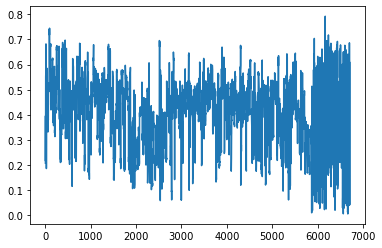

In [26]:
traj.ion_distance[:, -1]
plt.plot(np.linspace(0, len(traj.ion_distance[:, -1]), len(traj.ion_distance[:, -1])), traj.ion_distance[:, -1])
plt.show()

In [24]:
traj.group_molecules(path=r'/home/ibrahimk95/Documents/n2p2_sims/working_files/needs_testing/failed_clustering_run/')

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

In [12]:
traj.n_atoms

383

In [28]:
traj.remove_atoms(N=101, snap=300, format_out="lammps")

(127, 5) (256, 5)
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
(26, 5) (53, 5)


In [47]:
traj2 = Trajectory("reduced_water.lammpstrj")
traj2.get_box_size()
traj2.s1, traj2.s2 = traj2.split_species()
print(traj2.s1)

Processing Snapshot:1
[array([[5.92600e+03, 1.00000e+00, 1.70260e-01, 2.87872e-01, 3.48330e-02],
       [1.16020e+04, 1.00000e+00, 1.25171e-01, 4.25715e-01, 2.22317e-01],
       [1.03470e+04, 1.00000e+00, 9.17387e-03, 4.11117e-01, 9.73607e-01],
       ...,
       [3.60300e+03, 1.00000e+00, 9.48402e-01, 5.29586e-01, 5.46967e-01],
       [3.60200e+03, 1.00000e+00, 9.20487e-01, 5.25505e-01, 5.50430e-01],
       [2.98300e+03, 1.00000e+00, 8.75902e-01, 5.02455e-01, 6.35631e-01]])]


In [48]:
traj2.indexlist, _ = traj2.get_neighbour_KDT(mode="pbc")

Atribute Error occured(recieved list instead of numpy array) using first element of list instead


In [49]:
traj2.get_displace(snapshot = 0, id = None, distance=0.5, eps=0.01, dp_factor = 0.99,
                     path=None, num_traj=None)

0.37333755555796955
distance too far next O
0.5706349544963049
distance too far next O
0.6039576722360931
distance too far next O
0.6157085454378963
distance too far next O
0.4741110273269332
distance too far next O
0.4269542310623001
distance too far next O
0.5898473724265032
distance too far next O
0.3018054030762206
distance too far next O
0.3816345303742837
distance too far next O
0.2249826956017951
distance too far next O
0.4943871787708496
displace
trajectory saved as water.data


In [50]:
traj.group_molecules()

Atribute Error occured(recieved list instead of numpy array) using first element of list instead


In [25]:
traj.get_ion_distance()

array([[0.00000000e+00, 9.74471000e-01, 6.48596000e-01, ...,
        6.99036000e-01, 3.12085000e-01, 2.07666506e-01],
       [1.00000000e+00, 8.20679000e-01, 4.37983000e-01, ...,
        6.95657000e-01, 3.13206000e-01, 3.90856603e-01],
       [2.00000000e+00, 8.22932000e-01, 4.34909000e-01, ...,
        6.90487000e-01, 3.07421000e-01, 3.95979244e-01],
       ...,
       [6.70800000e+03, 3.91601000e-01, 7.02130000e-01, ...,
        7.39527000e-01, 2.40548000e-01, 4.15018401e-02],
       [6.70900000e+03, 3.86452000e-02, 9.89095000e-01, ...,
        7.34320000e-01, 2.16037000e-01, 4.50582879e-01],
       [6.71000000e+03, 3.92238000e-01, 7.26479000e-01, ...,
        3.59772000e-01, 1.96581000e-01, 6.08127191e-01]])